# Impacto do processo de LabelEncoder para variáveis Categóricas Ordinais

### Hipótese Proposta
Quando falamos de análise de dados, podemos dividir as variáveis em **numéricas** e **categóricas**. As categóricas podem ser **nominais**, ou seja, aquelas não mensuráveis, ou **ordinais**, aquelas que podem ser categorizadas sob uma determinada ordenação.
A ideia proposta busca verifica qual o impacto do processo de preprocessamento de dados LabelEncoder para variáveis ordinais.

A fim de explicar o fundamento por trás da proposta, considere o seguinte exemplo ilustrativo:
Dado um dataset com um atributo *faixa_etária*, com os possíveis valores (*criança*, *adolescente*, *jovem*, *adulto*, *idoso*). Busca-se predizer se tal indivíduo sofre de um doença que sabe-se que há um tendência de manifestação dela conforme o passar da idade (como por exemplo câncer).

### Funcionamento do processo de LabelEncoder
O processo de preprocessamento LabelEncoder transforma os valores de variáveis categóricas em valores numéricos de 0 a n-1, onde n é o numero de valores únicos encontrados para aquela variável. Porém, essa transformação é **feita sempre em ordem alfabética**, ou seja, organiza-se os valores em ordem alfabética e, seguindo essa ordem, associa os valores numéricos.

Dado o exemplo anterior, os possíveis valores para a variável *faixa_etária* são (*criança*, *adolescente*, *jovem*, *adulto*, *idoso*), ou seja, são 5 possíveis valores, logo eles receberão valores de 0 a 4. Dessa forma, tem-se as seguintes associações:

**adolescente = 0; adulto = 1; criança = 2; idoso = 3; jovem = 4**

### Mais sobre a Hipótese
A hipótese propõe que a atribuição de valores seguindo a relação de ordenação entre os valores da variável pode implicar em melhoria da eficiência dos algoritmos de machine learning em relação a atribuição de valores de forma convencional, como é feito pelo LabelEncoder.

Ou seja, utilizando o exemplo acima, adotar as seguintes associações:
**criança = 0; adolescente = 1; jovem = 2; adulto = 3; idoso = 4**
resultaria em um modelo de machine learning com melhor precisão, pois permitiria ao modelo enxergar melhor essa tendência existente

In [67]:
# ===== Importacao de Bibliotecas ===== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [47]:
def cria_dicionario(lista):
    dict_lista = {}
    for i in range(len(lista)):
        dict_lista[lista[i]] = i
    
    return dict_lista

def especial_LabelEncoder(dicionarios, colunas):
    for n in range(len(previsores2)):
        for dicionario, col in zip(dicionarios, colunas):
            for key, val in dicionario.items():
                if previsores2[n][col] == key:
                    previsores2[n][col] = val
                    break

In [49]:
def create_test_model(i_train, i_test):
    modelo1 = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=2)
    modelo1.fit(previsores1[i_train], classe[i_train])
    previsoes1 = modelo1.predict(previsores1[i_test])
    score1 = accuracy_score(classe[i_test], previsoes1)
    
    modelo2 = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=2)
    modelo2.fit(previsores2[i_train], classe[i_train])
    previsoes2 = modelo2.predict(previsores2[i_test])
    score2 = accuracy_score(classe[i_test], previsoes2)
    
    return score1, score2

In [200]:
def avalia_modelo(n_seeds):
    global precisao1, precisao2
    
    for seed in range(n_seeds):
        kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        
        score_seed1 = []
        score_seed2 = []
        for i_train, i_test in kfold.split(previsores1, np.zeros(shape=(classe.shape[0], 1))):
            score1, score2 = create_test_model(i_train, i_test)
            
            score_seed1.append(score1)
            score_seed2.append(score2)
        
        score_seed1 = np.array(score_seed1)
        score_seed2 = np.array(score_seed2)
        
        precisao1.append(score_seed1.mean())
        precisao2.append(score_seed2.mean())
        
        if score_seed1.mean() > score_seed2.mean():
            print("seed {}: Score 1 - {:.5f} > {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
        elif score_seed1.mean() < score_seed2.mean():
            print("seed {}: Score 2 - {:.5f} < {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
        else:
            print("seed {}: Empate - {:.5f} = {:.5f}".format(seed, score_seed1.mean(), score_seed2.mean()))
    
    precisao1 = np.array(precisao1)
    precisao2 = np.array(precisao2)
    print("Media: \n 1: {:.5f}\n 2: {:.5f}".format(precisao1.mean(), precisao2.mean()))
    
    return precisao1.mean(), precisao2.mean()

In [178]:
base = pd.read_csv("Credito.csv", sep=";", encoding="latin1")

In [179]:
# Analise da do dataset permite identificar 4 atributos categoricos ordinais
cheq_esp = list(base['CHEQUEESPECIAL'].unique())
bal_med_cred = list(base['BALANCO_MEDIO_CREDITO'].unique())
empregado = list(base['EMPREGADO'].unique())
emprego = list(base['EMPREGO'].unique())

print(cheq_esp)
print(bal_med_cred)
print(empregado)
print(emprego)

['<0', '0<=X<200', 'sem cheque', '>=200']
['nenhuma economia conhecida', '<100', '500<=X<1000', '>=1000', '100<=X<500']
['>=7', '1<=X<4', '4<=X<7', 'desempregado', '<1']
['especializado', 'não especializado', 'alta qualificação/autonomo/Gerente', 'unemp/unespecializado non res']


In [180]:
cheq_esp = ['<0', '0<=X<200', '>=200', 'sem cheque']
bal_med_cred = ['nenhuma economia conhecida', '<100', '100<=X<500', '500<=X<1000', '>=1000']
empregado = ['desempregado', '<1', '1<=X<4', '4<=X<7', '>=7']
emprego = ['unemp/unespecializado non res', 'não especializado', 'especializado', 'alta qualificação/autonomo/Gerente']

dict_cheq_esp = cria_dicionario(cheq_esp)
dict_bal_med_cred = cria_dicionario(bal_med_cred)
dict_empregado = cria_dicionario(empregado)
dict_emprego = cria_dicionario(emprego)

all_dict = [dict_cheq_esp, dict_bal_med_cred, dict_empregado, dict_emprego]

In [181]:
# Divisao dos atributos previsores e classe
previsores1 = base.iloc[:, 0:19].values # atributos previsores p/ utilizar LabelEncoder
previsores2 = base.iloc[:, 0:19].values # atributos previsores p/ utilizar processo proposto
classe = base.iloc[:, 19].values

In [182]:
# Preprocessamento LabelEncoder
encoder = LabelEncoder()

# Processo tradicional de LabelEncoder para todas as colunas com atributos categoricos
colunas = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18]
for c in colunas:
    previsores1[:, c] = encoder.fit_transform(previsores1[:, c])

# Processo tradicional de LabelEncoder somente para as colunas com atributos categoricos não ordinais
colunas = [2, 3, 8, 9, 11, 13, 14, 18]
for c in colunas:
    previsores2[:, c] = encoder.fit_transform(previsores1[:, c])

# Processo proposto de LabelEncoder para atributos ordinais
colunas = [0, 5, 6, 16]
especial_LabelEncoder(all_dict, colunas)


classe = encoder.fit_transform(classe)

In [183]:
# Preprocessamento Escalonamento
scaler = StandardScaler()
previsores1 = scaler.fit_transform(previsores1)
previsores2 = scaler.fit_transform(previsores2)

In [184]:
# Avaliação
n_seed = 20
precisao1 = []
precisao2 = []

media1, media2 = avalia_modelo(n_seed)

seed 0: Score 2 - 0.73600 < 0.74500
seed 1: Score 2 - 0.72300 < 0.75500
seed 2: Score 2 - 0.72500 < 0.74300
seed 3: Score 2 - 0.71600 < 0.73800
seed 4: Score 2 - 0.71900 < 0.74000
seed 5: Score 2 - 0.70800 < 0.74400
seed 6: Score 2 - 0.71400 < 0.73600
seed 7: Score 2 - 0.71400 < 0.74600
seed 8: Score 2 - 0.72700 < 0.73900
seed 9: Score 2 - 0.72600 < 0.74400
seed 10: Score 2 - 0.71500 < 0.74300
seed 11: Score 2 - 0.71400 < 0.73700
seed 12: Score 2 - 0.71700 < 0.74100
seed 13: Score 2 - 0.72000 < 0.74600
seed 14: Score 2 - 0.72900 < 0.74400
seed 15: Score 2 - 0.72100 < 0.74500
seed 16: Score 2 - 0.73100 < 0.76300
seed 17: Score 2 - 0.73000 < 0.75200
seed 18: Score 2 - 0.71900 < 0.74000
seed 19: Score 2 - 0.71100 < 0.74800
Media: 
 1: 0.72075
 2: 0.74445


In [ ]:
# Resultados com KNN
"""
seed 0: Score 2 - 0.73600 < 0.74500
seed 1: Score 2 - 0.72300 < 0.75500
seed 2: Score 2 - 0.72500 < 0.74300
seed 3: Score 2 - 0.71600 < 0.73800
seed 4: Score 2 - 0.71900 < 0.74000
seed 5: Score 2 - 0.70800 < 0.74400
seed 6: Score 2 - 0.71400 < 0.73600
seed 7: Score 2 - 0.71400 < 0.74600
seed 8: Score 2 - 0.72700 < 0.73900
seed 9: Score 2 - 0.72600 < 0.74400
seed 10: Score 2 - 0.71500 < 0.74300
seed 11: Score 2 - 0.71400 < 0.73700
seed 12: Score 2 - 0.71700 < 0.74100
seed 13: Score 2 - 0.72000 < 0.74600
seed 14: Score 2 - 0.72900 < 0.74400
seed 15: Score 2 - 0.72100 < 0.74500
seed 16: Score 2 - 0.73100 < 0.76300
seed 17: Score 2 - 0.73000 < 0.75200
seed 18: Score 2 - 0.71900 < 0.74000
seed 19: Score 2 - 0.71100 < 0.74800
Media: 
 1: 0.72075
 2: 0.74445
"""

### Analise da Tendência na relação das variaveis ordinais e a classe
A análise feita a seguir mostra possíveis tendências na relacao entre os atributos ordinais e porcentagem de registros de bons/maus pagadores.

Essa análise pode auxiliar na definição da melhor ordem a ser seguida no processo de LabelEncoder personalizado e ao realizar a alteração pode-se avaliar a resposta obtida utilizando o código acima a fim de confirmar que a mudança de fato gera uma melhora no resultado

In [197]:
def analise_atributo_bar(atributo):
    from math import ceil
    n_row = ceil(len(base[atributo].unique())/2)
    j = 1
    plt.figure(figsize=(10,9))
    for opt_value in base[atributo].unique():
        registros = base.loc[base[atributo] == opt_value]
        
        reg_bom = len(registros.loc[registros['CLASSE'] == 'bom'])
        reg_ruim = len(registros.loc[registros['CLASSE'] == 'ruim'])
        
        plt.subplot(n_row, 2, j)
        plt.pie([reg_bom, reg_ruim], labels=['Bom', 'Ruim'], startangle=90, counterclock=False,
                autopct=lambda p: '{:.1f}%'.format(p))
        plt.title('{}'.format(str(opt_value).title()))
        
        j += 1

def analise_atributo(atributo):
    ordem_orig = base[atributo].unique()
    ordem_prop = ordem_proposta(atributo)
    
    reg_tot = []
    reg_bom = []
    plt.figure(figsize=(12,9))
    plt.subplot(2,1,1)
    for opt_value in ordem_orig:
        registros = base.loc[base[atributo] == opt_value]
        reg_tot.append(len(registros))
        reg_bom.append(len(registros.loc[registros['CLASSE'] == 'bom']))
    for i in range(len(reg_bom)):
        reg_bom[i] = reg_bom[i]/reg_tot[i] * 100

    #plt.bar(ordem_orig, reg_tot)
    #plt.bar(ordem_orig, reg_bom, color='orange')
    plt.plot(ordem_orig, reg_bom, 'o-')
    plt.ylabel('% Bom Pagadores')
    plt.title('Ordem Original')
    
    
    # ORDEM PROPOSTA
    reg_tot = []
    reg_bom = []
    plt.subplot(2,1,2)
    for opt_value in ordem_prop:
        registros = base.loc[base[atributo] == opt_value]
        reg_tot.append(len(registros))
        reg_bom.append(len(registros.loc[registros['CLASSE'] == 'bom']))
    for i in range(len(reg_bom)):
        reg_bom[i] = reg_bom[i]/reg_tot[i] * 100

    #plt.bar(ordem_prop, reg_tot)
    #plt.bar(ordem_prop, reg_bom, color='orange')
    plt.plot(ordem_prop, reg_bom, color='orange', marker='o')
    plt.ylabel('% Bom Pagadores')
    plt.title('Ordem Proposta')

In [198]:
def ordem_proposta(atributo):
    if atributo == 'CHEQUEESPECIAL':
        return cheq_esp
    elif atributo == 'BALANCO_MEDIO_CREDITO':
        return bal_med_cred
    elif atributo == 'EMPREGADO':
        return empregado
    elif atributo == 'EMPREGO':
        return emprego

Ordem original: ['especializado' 'não especializado' 'alta qualificação/autonomo/Gerente'
 'unemp/unespecializado non res']
Ordem proposta: ['unemp/unespecializado non res', 'não especializado', 'especializado', 'alta qualificação/autonomo/Gerente']


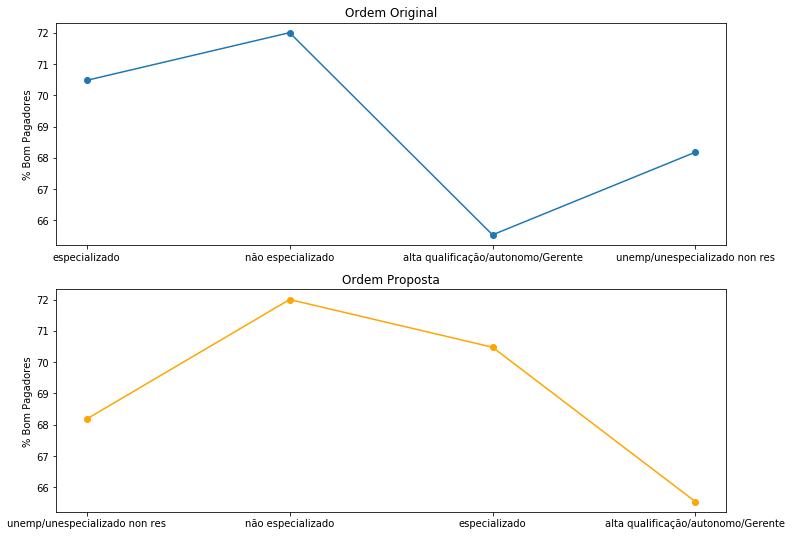

In [199]:
# atributos = 'CHEQUEESPECIAL', 'BALANCO_MEDIO_CREDITO', 'EMPREGADO', 'EMPREGO'
chosen_att = 'EMPREGO'
print("Ordem original: {}".format(base[chosen_att].unique()))
print("Ordem proposta: {}".format(ordem_proposta(chosen_att)))

analise_atributo(chosen_att)